In [1]:
import plotly.express as px
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point


- [vscode](https://code.visualstudio.com/download)
- [markdown](https://www.markdownguide.org/cheat-sheet/)
- [jupyter](https://jupyter.org/)



## Чтение данных

In [3]:
meteo = pd.read_csv('../data/NorwayMeteoDataCompleted.csv')

In [4]:
meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237629 entries, 0 to 237628
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     237629 non-null  int64  
 1   sourceId                       237629 non-null  object 
 2   latitude                       237629 non-null  float64
 3   longtitude                     237629 non-null  float64
 4   max(air_temperature P1D)       44766 non-null   float64
 5   max(relative_humidity P1D)     36965 non-null   float64
 6   max(wind_speed P1D)            35260 non-null   float64
 7   mean(air_temperature P1D)      63551 non-null   float64
 8   mean(relative_humidity P1D)    37411 non-null   float64
 9   mean(wind_speed P1D)           35260 non-null   float64
 10  sum(precipitation_amount P1D)  107937 non-null  float64
 11  day                            237629 non-null  int64  
 12  month                         

In [5]:
meteo_air = meteo[meteo['mean(air_temperature P1D)'].notnull()]
meteo.latitude.unique()
coor = meteo[['sourceId','latitude','longtitude']].drop_duplicates()
coor.shape


(55, 3)

<p style = "background-color : DodgerBlue; border-radius: 5px 5px; padding : 3px"><strong></strong></p> 

## Графики
<p style = "background-color : DarkGreen; border-radius: 5px 5px; padding : 3px"><strong></strong></p> 

### 1. Начальный график

In [6]:
fig = px.choropleth(
    data_frame=meteo,
    locations=['Norway'], #столбец с локациями
    locationmode = "country names", #режим сопоставления локаций с базой Plotly
    color_continuous_scale='tropic', #палитра цветов
    scope='europe', # указываем что работаем только с диапазоном Европа
    fitbounds='locations', # фитим только диапазон Европы только затронутых стран
    projection = 'natural earth', # стиль отображения карты - данный лучше подходит в нашем случае
)

fig.add_scattergeo(
#   locations = covid_data_full.Country,
  lat=coor.latitude,
  lon=coor.longtitude, 
  locationmode='country names',

)

fig.show()

### Получение геометрии стран

In [7]:
path_to_data = gpd.datasets.get_path("naturalearth_lowres")
gdf = gpd.read_file(path_to_data)
json = gpd.GeoSeries(gdf[gdf.name == 'Russia'].geometry).__geo_interface__
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   pop_est     177 non-null    float64 
 1   continent   177 non-null    object  
 2   name        177 non-null    object  
 3   iso_a3      177 non-null    object  
 4   gdp_md_est  177 non-null    int64   
 5   geometry    177 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 8.4+ KB


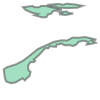

In [8]:
gdf.geometry.iloc[21]

In [9]:
coor['in'] = coor.apply(lambda x: gdf.geometry.iloc[21].contains(Point(x.longtitude,x.latitude)), axis=1)
print(gdf.geometry.iloc[21].centroid)

POINT (15.468119955206761 69.15685630975351)


### График с вышками на территории Норвегии только

In [10]:
coor_cleaned = coor[coor['in'] ==True] 

fig = px.choropleth(
    color_continuous_scale='tropic', #палитра цветов
    scope='europe', # указываем что работаем только с диапазоном Европа
    fitbounds='geojson',
    projection = 'natural earth', # стиль отображения карты - данный лучше подходит в нашем случае
)

fig.add_scattergeo(
  lat=coor_cleaned.latitude,
  lon=coor_cleaned.longtitude, 
  locationmode='country names',
  mode = 'markers',
  marker_color = coor_cleaned.latitude,
  customdata=coor_cleaned.sourceId,
  texttemplate='<b style=" font-size:12px;">%{x}</b><br>%{customdata}',
  hovertemplate='<b style=" font-size:12px;">%{lon} : %{lat}</b><br>%{customdata}',
)

fig.update_layout(
    geo = dict(
        showland = True,
        countrycolor = "gray",
        showlakes = True,
        lakecolor = "lightblue",
        showsubunits = True,
        showcountries = True,
        resolution = 50,
     ),
)

fig.update_geos(
  fitbounds="geojson",
  projection_type= "natural earth2"
)

fig.show()

In [11]:
meteo_air_s = meteo_air[meteo_air.sourceId.isin(list(coor_cleaned.sourceId))]
meteo_air_w = meteo_air_s[meteo_air_s['max(wind_speed P1D)'].notnull()].\
  groupby(['sourceId','latitude','longtitude'], as_index=False).mean()[['sourceId','max(wind_speed P1D)','latitude','longtitude']]
meteo_air_w.columns = ['id','wspeed','latitude','longtitude']

In [12]:
fig = px.choropleth(
    geojson=json, 
    scope='europe', # указываем что работаем только с диапазоном Европа
    color_continuous_scale = 'ylgnbu', 
    color = meteo_air_w.wspeed,
    fitbounds='geojson',
    projection = 'natural earth', # стиль отображения карты - данный лучше подходит в нашем случае

)



fig.add_scattergeo(
#   locations = covid_data_full.Country,
  lat=meteo_air_w.latitude,
  lon=meteo_air_w.longtitude, 
  locationmode='country names',
  mode = 'markers',
  marker=dict(color=meteo_air_w.wspeed,
              colorscale='ylgnbu',
              size=15,
              opacity = .99,
              coloraxis="coloraxis",
              symbol='square-x',
  ),

  customdata = np.stack((meteo_air_w.id,meteo_air_w.wspeed), axis=-1),

  hovertemplate='<b style="font-size:12px;">%{lon} : %{lat}</b>\
    <br>Station: %{customdata[0]}\
    <br>Average Wind: %{customdata[1]:,.2} m/s',
)



fig.update_layout(
    geo = dict(
        showland = True,
        # landcolor = "rgb(212, 212, 212)",
        countrycolor = "gray",
        showlakes = True,
        lakecolor = "lightblue",
        showsubunits = True,
        showcountries = True,
        resolution = 50,
     ),
    coloraxis_colorbar=dict(
        title="Средняя скорость ветра", # меняем заголовок для цветного бара справа
        title_side="right", # разместим надпись справа
        tickformat = ",.2", # выставляем чтобы тики указывали % для более удобного восприятия
        ticksuffix=' м/с'
    ),      
)


fig.show()